<a href="https://colab.research.google.com/github/nikhilbansal23/GettInsights-from-Failed-Orders/blob/main/Insights_from_Failed_Orders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import uuid
from datetime import datetime
from scipy.stats import norm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objs as go
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [40]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
data_offers = pd.read_csv('/content/drive/MyDrive/Datasets/Gett Insights from Failed Orders/data_offers.csv')
data_orders = pd.read_csv('/content/drive/MyDrive/Datasets/Gett Insights from Failed Orders/data_orders.csv')

In [5]:
data_offers.head(5)

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [7]:
print('Data Offers Count '+str(len(data_offers)))
print('Data Orders Count '+str(len(data_orders)))

Data Offers Count 334363
Data Orders Count 10716


In [6]:
data_orders.head(5)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [8]:
df = data_orders.merge(right=data_offers, how="inner", on="order_gk")

In [9]:
print('Data Count '+str(len(df)))

Data Count 31268


In [12]:
df.sample(n=10, random_state=42)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,cancellations_time_in_seconds,offer_id,is_driver_assigned,order_status
30194,21:15:35,-0.969588,51.455780,299.0,3000555697076,223.0,300050725946,Yes,Client Cancelled
14748,10:13:35,-0.955958,51.430362,NaN,3000626091676,91.0,300052014519,No,Client Cancelled
29083,09:16:38,-1.033560,51.441967,NaN,3000594099225,68.0,300051458740,No,Client Cancelled
16926,02:08:09,-0.967676,51.444489,NaN,3000626980467,125.0,300052031394,No,Client Cancelled
21530,21:44:21,-0.972683,51.456762,NaN,3000554421440,11.0,300050671163,No,Client Cancelled
13008,03:03:45,-0.966745,51.453236,NaN,3000593295623,NaN,300051413313,No,System Reject
2034,14:41:22,-0.948642,51.449587,NaN,3000584916226,6.0,300051090742,No,Client Cancelled
2229,20:54:03,-0.991382,51.476339,NaN,3000585716553,NaN,300051125957,No,System Reject
16632,18:06:17,-0.948907,51.444643,NaN,3000627382471,113.0,300052078801,No,Client Cancelled
18189,07:52:29,-0.973793,51.458665,479.0,3000587781360,47.0,300051178628,Yes,Client Cancelled


In [11]:
df["is_driver_assigned"] = np.where(df["is_driver_assigned_key"] == 1, "Yes", "No")
df["order_status"] = np.where(df["order_status_key"] == 4, "Client Cancelled", "System Reject")

df.drop(columns=["is_driver_assigned_key", "order_status_key"], inplace=True)

## **Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?**

In [18]:
ques_1 = df.groupby(['is_driver_assigned','order_status'])['order_gk'].count().reset_index()
ques_1.rename({'order_gk':'Order_Count'},axis = 1,inplace=True)
ques_1

,is_driver_assigned,order_status,Order_Count
0,No,Client Cancelled,13435
1,No,System Reject,9469
2,Yes,Client Cancelled,8360
3,Yes,System Reject,4


In [20]:
# Create a bar plot using Plotly
fig = px.bar(ques_1, x='is_driver_assigned', y='Order_Count', color='order_status',
             barmode='group', labels={'Order_Count': 'Count', 'is_driver_assigned': 'Driver Assigned'})
fig.update_layout(title='Counts of is_driver_assigned by order_status', xaxis_title='Driver Assigned')
fig.show()

# Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31268 entries, 0 to 31267
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_datetime                 31268 non-null  datetime64[ns]
 1   origin_longitude               31268 non-null  float64       
 2   origin_latitude                31268 non-null  float64       
 3   m_order_eta                    8364 non-null   float64       
 4   order_gk                       31268 non-null  int64         
 5   cancellations_time_in_seconds  21795 non-null  float64       
 6   offer_id                       31268 non-null  int64         
 7   is_driver_assigned             31268 non-null  object        
 8   order_status                   31268 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 2.4+ MB


In [32]:
df.groupby('order_status').count()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,cancellations_time_in_seconds,offer_id,is_driver_assigned,order_hour
order_status,,,,,,,,,
Client Cancelled,21795,21795,21795,8360,21795,21795,21795,21795,21795
System Reject,9473,9473,9473,4,9473,0,9473,9473,9473


In [22]:
df['order_datetime'] = pd.to_datetime(df['order_datetime'])

In [26]:
# Extract hour into a new column 'hour'
df['order_hour'] = df['order_datetime'].dt.hour


The four system rejects with the assigned driver occurred around midnight (see the output of the grouped DataFrame). The rest of the categories follow similar distribution, with the client cancellations with the assigned driver having a substantially lower count during the night hours.

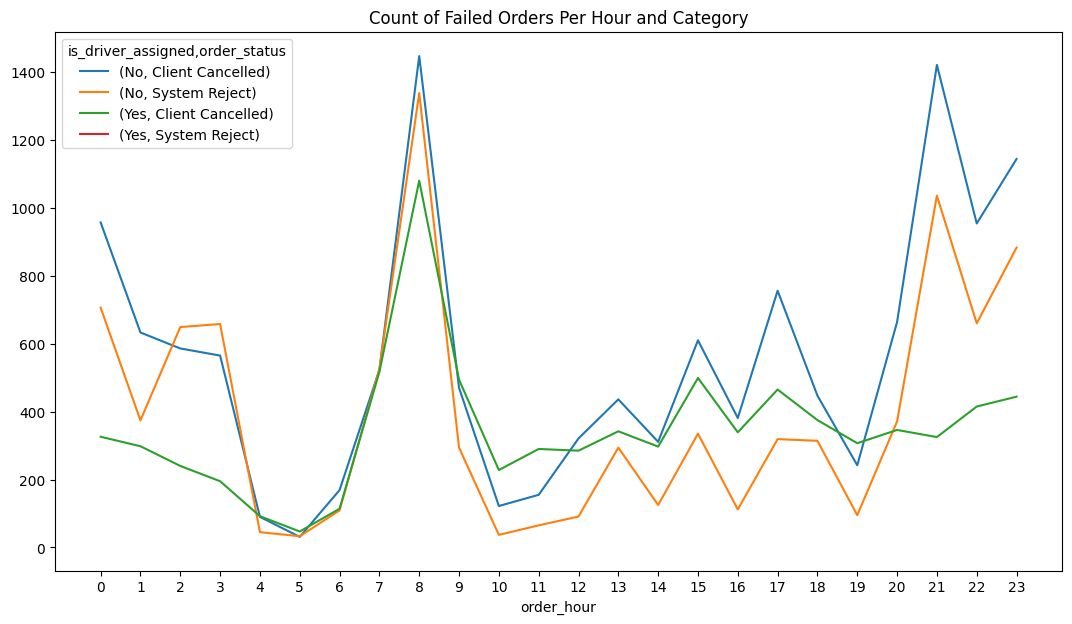

In [46]:
ques_2 = df.groupby(['is_driver_assigned','order_status','order_hour'])['order_gk'].count().reset_index()
ques_2.rename({'order_gk':'Order_Count'},axis = 1,inplace=True)
# ques_2
a = ques_2.reset_index().pivot(index="order_hour",
                                   columns=["is_driver_assigned", "order_status"],
                                   values="Order_Count").plot(xticks=range(0, 24),
                                                           figsize=(13, 7),
                                                           title="Count of Failed Orders Per Hour and Category")

# Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?

In [55]:
ques_3 = df.groupby(['is_driver_assigned','order_status','order_hour'])['cancellations_time_in_seconds'].mean().reset_index()
ques_3.rename({'cancellations_time_in_seconds':'Avg_time_cancellation'},axis = 1,inplace=True)
# ques_3

The average time to cancellation is higher on orders with an assigned driver than without, for each hour without exception. The peak occurs at 3 A.M. At this time there are a lot of client cancellations, so a logical explanation would be that clients have waited too long for the driver.

In [64]:
# Plotting with Plotly Express
fig = px.line(ques_3, x='order_hour', y='Avg_time_cancellation', color='is_driver_assigned',
              labels={'order_hour': 'Order Hour', 'Avg_time_cancellation': 'Avg Time to Cancellation'},
              title='Average Time to Cancellation by Hour with and without Driver')
fig.show()

# Plot the distribution of average ETA by hours. How can this plot be explained?

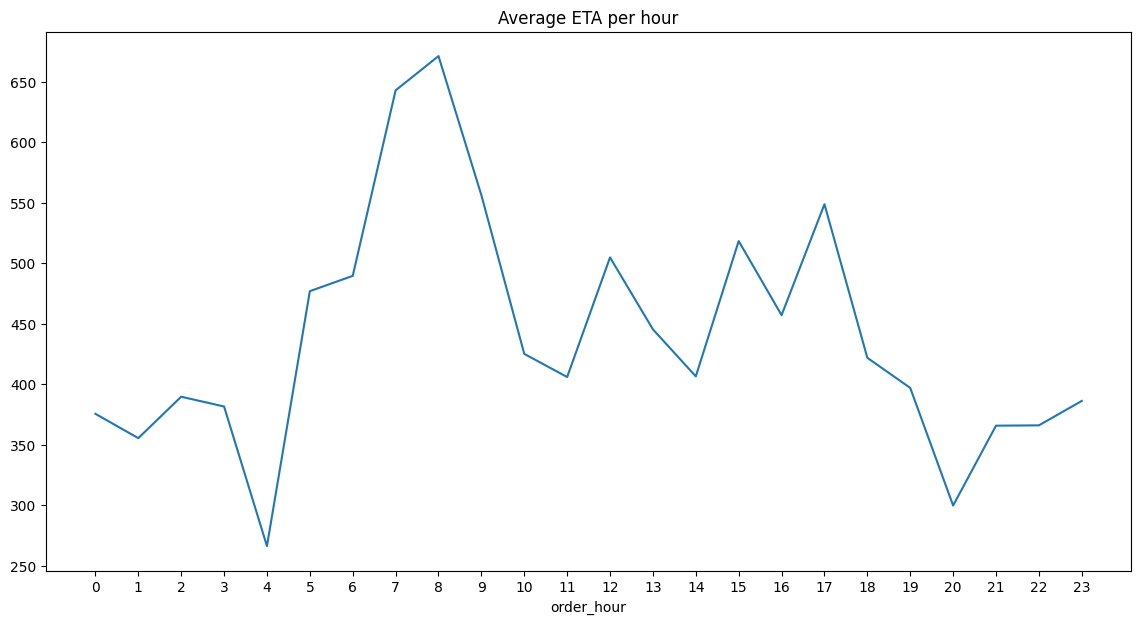

In [66]:
_ = df.groupby(by="order_hour")["m_order_eta"].mean().plot(figsize=(14, 7),
                                                           xticks=range(0, 24),
                                                           title="Average ETA per hour")

In [67]:
df.columns

Index(['order_datetime', 'origin_longitude', 'origin_latitude', 'm_order_eta',
       'order_gk', 'cancellations_time_in_seconds', 'offer_id',
       'is_driver_assigned', 'order_status', 'order_hour'],
      dtype='object')

## Using the h3 and folium packages, calculate how many size 8 hexes contain 80% of all orders from the original data sets and visualise the hexes, colouring them by the number of fails on the map.

In [69]:
pip install h3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.3 MB/s eta 0:00:00


In [70]:
import h3
import folium

In [71]:
df["hex_id"] = df.apply(
    func=lambda row: h3.geo_to_h3(lat=row["origin_latitude"], lng=row["origin_longitude"], resolution=8), axis=1)

In [72]:
grouped_q5 = df.groupby(by="hex_id")["order_gk"].count()
grouped_q5.shape

(139,)

In [73]:
grouped_q5 = grouped_q5.reset_index()
grouped_q5.sample(n=5, random_state=42)

,hex_id,order_gk
135,88195d74d1fffff,1
66,88195d2a33fffff,12
31,88195d2941fffff,52
118,88195d2b5dfffff,31
42,88195d2961fffff,5


To find the number of hexes that contain 80% of the orders, we will apply a cumulative percentage operation over the order_gk count column in the grouped_q5 DataFrame. This consists of the following steps:

Sort the DataFrame by the count.

Find the total number (sum) of failed orders.

Apply the method cumsum to find the cumulative sum of the order-count column.

Divide by the total sum to generate percentages.

Filter to find the row that is closest to 80%.

In [74]:
grouped_q5 = grouped_q5.sort_values(by="order_gk")  # 1
total_orders = grouped_q5["order_gk"].sum()  # 2
grouped_q5["cum_sum"] = grouped_q5["order_gk"].cumsum()  # 3
grouped_q5["cum_perc"] = 100 * grouped_q5["cum_sum"] / total_orders  # 4
grouped_q5[grouped_q5["cum_perc"] <= 80]  # 5

,hex_id,order_gk,cum_sum,cum_perc
137,88195d74d5fffff,1,1,0.003198
135,88195d74d1fffff,1,2,0.006396
79,88195d2aebfffff,1,3,0.009594
11,88195d282bfffff,1,4,0.012793
122,88195d3993fffff,1,5,0.015991
38,88195d2953fffff,1,6,0.019189
30,88195d2901fffff,2,8,0.025585
127,88195d39bbfffff,2,10,0.031982
134,88195d749dfffff,2,12,0.038378
126,88195d39b9fffff,3,15,0.047972


There are 137 rows in the final output, and 139 rows in the original grouped DataFrame, meaning that 137 hexagons contain around 80% of data, and only 2 hexagons contain the other 20%

In [75]:
map = folium.Map(location=[df["origin_latitude"].mean(), df["origin_longitude"].mean()],
                 zoom_start=8.5,  # after a bit of experimentation, we thought this presents the map best
                 tiles="cartodbpositron")

In [77]:
pip install geojson

In [78]:
import json
import geojson


def to_geojson(row):
    """Transform hex_id into a geojson object."""
    geometry = {
        "type": "Polygon",
        "coordinates": [h3.h3_to_geo_boundary(h=row["hex_id"], geo_json=True)]
    }
    return geojson.Feature(id=row["hex_id"], geometry=geometry, properties={"order_gk": row["order_gk"]})


geojsons = grouped_q5.apply(func=to_geojson, axis=1).values.tolist()
geojson_str: str = json.dumps(geojson.FeatureCollection(geojsons))


In [79]:
import matplotlib

# instantiate a colormap object for better visualisation
colormap = matplotlib.cm.get_cmap(name="plasma")
max_order_gk = grouped_q5["order_gk"].max()
min_order_gk = grouped_q5["order_gk"].min()

<ipython-input-79-8cc6e9cd18ed>:4: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



In [80]:
_ = folium.GeoJson(data=geojson_str, style_function=lambda f: {
    "fillColor": matplotlib.colors.to_hex(
        colormap((f["properties"]["order_gk"] - min_order_gk) / (max_order_gk - min_order_gk))),
    "color": "black",
    "weight": 1,
    "fillOpacity": 0.7
}).add_to(map)

In [81]:
map